In [1]:
!pip install pmdarima
!pip install numpy==1.26.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 35.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


Train size: 2544, Validation size: 318, Test size: 318
Kiểm định ADF trên chuỗi gốc:
ADF Statistic: 4.509747
p-value: 1.000000
Critical Value (1%): -3.433
Critical Value (5%): -2.863
Critical Value (10%): -2.567
=> Chuỗi không dừng (non-stationary)

Kiểm định ADF trên chuỗi sai phân bậc 1:
ADF Statistic: -7.865617
p-value: 0.000000
Critical Value (1%): -3.433
Critical Value (5%): -2.863
Critical Value (10%): -2.567
=> Chuỗi dừng (stationary)


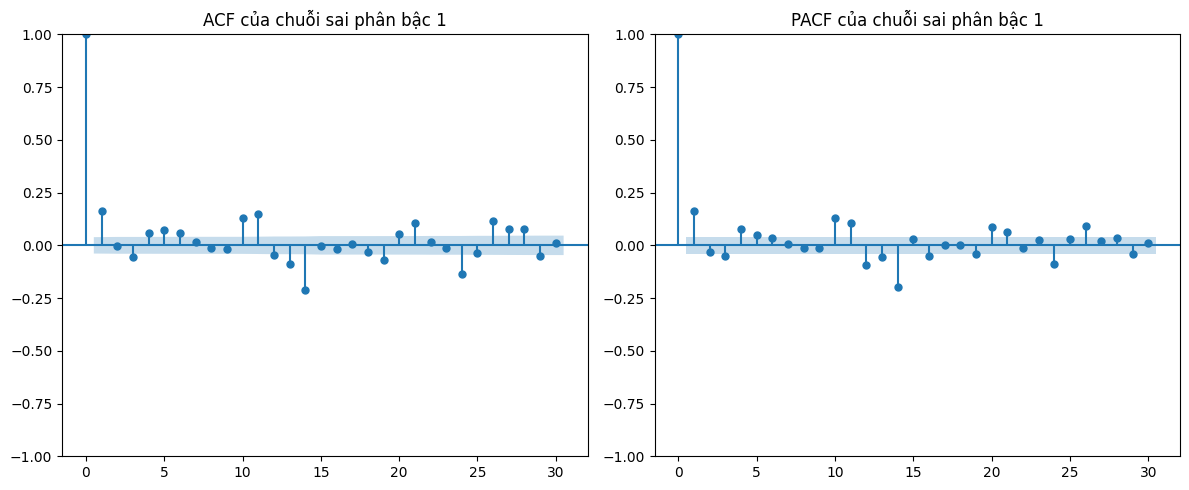

ARIMA(0,1,0) - AIC: 38000.17
ARIMA(0,1,1) - AIC: 37929.39
ARIMA(0,1,2) - AIC: 37930.65
ARIMA(0,1,3) - AIC: 37921.24
ARIMA(0,1,4) - AIC: 37919.29
ARIMA(1,1,0) - AIC: 37930.58
ARIMA(1,1,1) - AIC: 37930.97
ARIMA(1,1,2) - AIC: 37925.69
ARIMA(1,1,3) - AIC: 37921.67
ARIMA(1,1,4) - AIC: 37904.11
ARIMA(2,1,0) - AIC: 37929.88
ARIMA(2,1,1) - AIC: 37930.99
ARIMA(2,1,2) - AIC: 37917.22
ARIMA(2,1,3) - AIC: 37897.56
ARIMA(2,1,4) - AIC: 37807.41
ARIMA(3,1,0) - AIC: 37926.35
ARIMA(3,1,1) - AIC: 37922.45
ARIMA(3,1,2) - AIC: 37898.23
ARIMA(3,1,3) - AIC: 37904.18
ARIMA(3,1,4) - AIC: 37809.30
ARIMA(4,1,0) - AIC: 37912.67
ARIMA(4,1,1) - AIC: 37903.10
ARIMA(4,1,2) - AIC: 37905.06
ARIMA(4,1,3) - AIC: 37907.07
ARIMA(4,1,4) - AIC: 37808.52

Mô hình ARIMA tốt nhất: order=(2, 1, 4) với AIC=37807.41


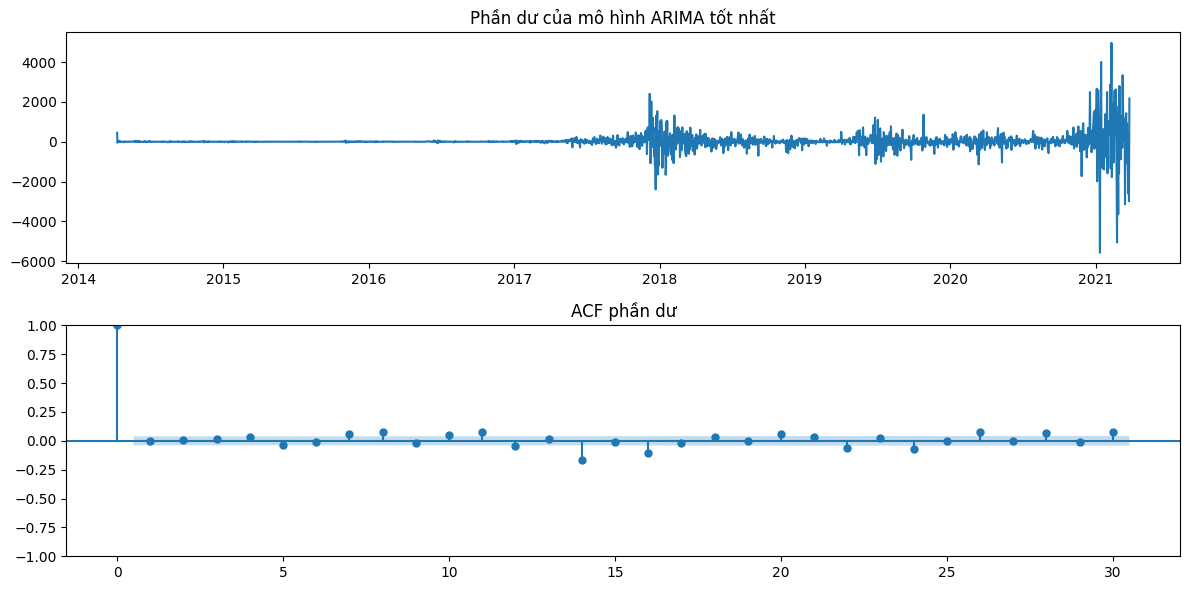

Validation MAE: 9592.63
Validation RMSE: 11281.39
Validation MAPE: 0.2342
Test MAE: 16942.97
Test RMSE: 19339.87
Test MAPE: 0.8179


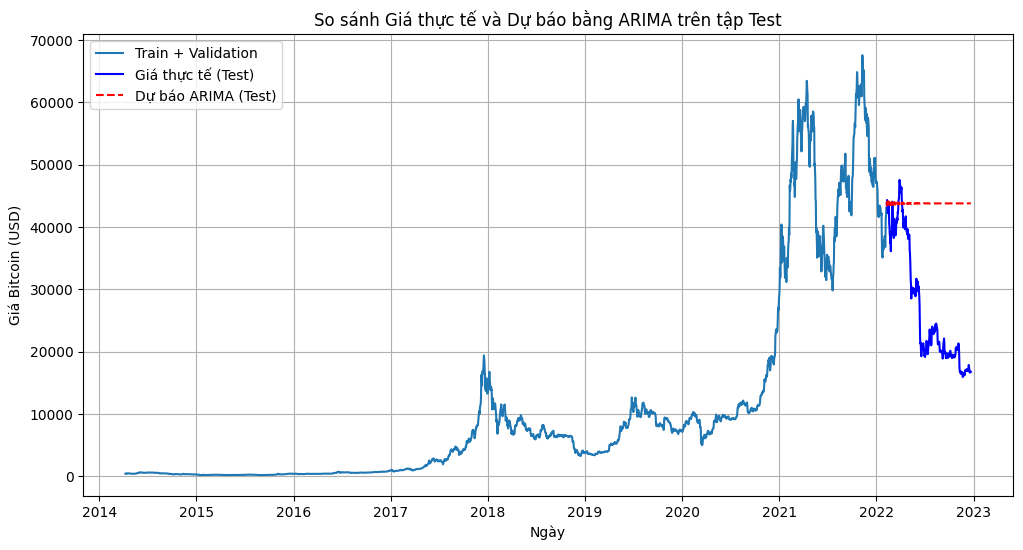

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 1. Đọc dữ liệu
df = pd.read_csv('/content/BTC_Data_final.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df[['Date', 'priceUSD']]
df.rename(columns={'Date': 'ds', 'priceUSD': 'y'}, inplace=True)
df.set_index('ds', inplace=True)

# 2. Chia dữ liệu train (80%), validation (10%), test (10%)
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train = df.iloc[:train_end]
validation = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

print(f"Train size: {len(train)}, Validation size: {len(validation)}, Test size: {len(test)}")

# 3. Kiểm định tính dừng với ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critical Value (%s): %.3f' % (key, value))
    if result[1] < 0.05:
        print("=> Chuỗi dừng (stationary)")
    else:
        print("=> Chuỗi không dừng (non-stationary)")

print("Kiểm định ADF trên chuỗi gốc:")
adf_test(train['y'])

# Nếu chuỗi không dừng, lấy sai phân 1 lần và kiểm định lại
train_diff = train['y'].diff().dropna()
print("\nKiểm định ADF trên chuỗi sai phân bậc 1:")
adf_test(train_diff)

# 4. Vẽ biểu đồ ACF và PACF trên chuỗi sai phân bậc 1
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(train_diff, lags=30, ax=plt.gca())
plt.title('ACF của chuỗi sai phân bậc 1')
plt.subplot(122)
plot_pacf(train_diff, lags=30, ax=plt.gca())
plt.title('PACF của chuỗi sai phân bậc 1')
plt.tight_layout()
plt.show()

# 5. Thử các tổ hợp (p,d,q) với d=1, chọn mô hình có AIC thấp nhất
best_aic = np.inf
best_order = None
best_model = None

for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(train['y'], order=(p,1,q))
            model_fit = model.fit()
            print(f"ARIMA({p},1,{q}) - AIC: {model_fit.aic:.2f}")
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p,1,q)
                best_model = model_fit
        except:
            continue

print(f"\nMô hình ARIMA tốt nhất: order={best_order} với AIC={best_aic:.2f}")

# 6. Kiểm tra phần dư của mô hình
residuals = best_model.resid
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Phần dư của mô hình ARIMA tốt nhất')
plt.subplot(212)
plot_acf(residuals, lags=30, ax=plt.gca())
plt.title('ACF phần dư')
plt.tight_layout()
plt.show()

# 7. Dự báo trên tập validation
start_val = validation.index[0]
end_val = validation.index[-1]
val_forecast = best_model.predict(start=start_val, end=end_val, typ='levels')

val_mae = mean_absolute_error(validation['y'], val_forecast)
val_rmse = np.sqrt(mean_squared_error(validation['y'], val_forecast))
val_mape = np.mean(np.abs((validation['y'] - val_forecast) / validation['y']))

print(f"Validation MAE: {val_mae:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Validation MAPE: {val_mape:.4f}")

# 8. Huấn luyện lại mô hình trên train + validation
train_val = pd.concat([train, validation])
final_model = ARIMA(train_val['y'], order=best_order)
final_model_fit = final_model.fit()

# 9. Dự báo trên tập test
start_test = test.index[0]
end_test = test.index[-1]
test_forecast = final_model_fit.predict(start=start_test, end=end_test, typ='levels')

# 10. Đánh giá mô hình trên test
test_mae = mean_absolute_error(test['y'], test_forecast)
test_rmse = np.sqrt(mean_squared_error(test['y'], test_forecast))
test_mape = np.mean(np.abs((test['y'] - test_forecast) / test['y']))

print(f"Test MAE: {test_mae:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAPE: {test_mape:.4f}")

# 11. Vẽ biểu đồ so sánh giá thực tế và dự báo trên test
plt.figure(figsize=(12,6))
plt.plot(train_val.index, train_val['y'], label='Train + Validation')
plt.plot(test.index, test['y'], label='Giá thực tế (Test)', color='blue')
plt.plot(test_forecast.index, test_forecast, label='Dự báo ARIMA (Test)', color='red', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Giá Bitcoin (USD)')
plt.title('So sánh Giá thực tế và Dự báo bằng ARIMA trên tập Test')
plt.legend()
plt.grid(True)
plt.show()
